In [3]:
import sys
import importlib

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf

In [15]:
importlib.reload(lf)

<module 'letkf_forecasting' from '/home/travis/python_code/letkf_forecasting/letkf_forecasting.py'>

In [6]:
#for Golem
sat_14 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_14.nc')
sat_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_15.nc')
wind_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/wind_15_crop.nc')
sensor_data = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_data.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_loc.h5')

In [7]:
clear_sky_good = xr.DataArray(
    data=sat_15.GHI.values/sat_14.GHI.values,
    coords=sat_15.coords)

sat_15['clear_sky_good'] = clear_sky_good

In [8]:
sensor_CI = sensor_data[['clearsky_index', 'id']]
sensor_CI = sensor_CI.reset_index().pivot(
    index='time', columns='id', values='clearsky_index')
sensor_CI = sensor_CI.resample('5min').mean().dropna()

In [9]:
#This is taken from http://www.groundcontrol.com/Satellite_Look_Angle_Calculator.html
goes15_azimuth = 220.5*(2*np.pi)/360
goes15_elevation = 44.1*(2*np.pi)/360

time = pd.Timestamp('2014-04-15 11:00:00').tz_localize('MST')
tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')
solar_position = tus.get_solarposition(time)
lf.parallax_shift(2000,
                     goes15_azimuth,
                     goes15_elevation,
                     solar_position['azimuth'].values*np.pi/360,
                     solar_position['elevation'].values*np.pi/360)

(array([ 4502.7974688]), array([ 2902.55179225]))

0.129446470644


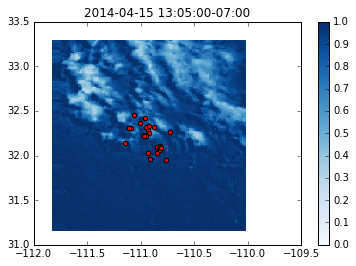

KeyboardInterrupt: 

In [34]:
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = .7
assimilation_grid_size = 4
localization = 12

start_time = '2014-04-15 13:00:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

lf.simulation(sat_15, wind_15, sensor_CI, sensor_loc,
           start_time, end_time, dx, dy, C_max,
           assimilation_grid_size, localization)